## Seminar 5 - Dense Prediction

Your task is to convert image classification network into fully-convolutional network that predicts value for every patch on image.

What we have:
* network trained to predict whether the central pixel of patch of size 114x114 belong to class 'road'
* image that we want to segment

Let's firstly look on the data

In [74]:
import scipy as sp
import scipy.misc
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [75]:
# if running in colab or datasphere, uncomment this:
if 'google.colab' in str(get_ipython()):
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/um_000081-pred.png -O um_000081-pred.png")
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/layer_wrappers.py -O layer_wrappers.py")
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/um_000081.png -O um_000081.png")
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/um_road_000081.png -O um_road_000081.png")

In [76]:
%pip install scikit-image

In [77]:
if not os.path.exists('model2.npz'):
    os.system("wget https://www.dropbox.com/s/429eqmyi3dbhzrg/model2.npz?dl=0 -O model2.npz")
# alternative link: https://yadi.sk/d/I1kHDWZTnH4DAw (for manual downloading only)

In [78]:
def read_image(img_name, gt_name=None):
    IMG_HEIGHT = 256
    im = skimage.io.imread(img_name)
    im = skimage.transform.rescale(im, IMG_HEIGHT * 1. / im.shape[0], multichannel=True)
    im = skimage.img_as_ubyte(im)
    if gt_name is not None:
        gt = (skimage.io.imread(gt_name)[:,:,-1]==255).astype(np.uint8)*255
        gt = skimage.transform.rescale(gt, IMG_HEIGHT * 1. / gt.shape[0], order=0, preserve_range=True)
        gt = (gt > 0).astype(np.uint8)
        return im, gt
    return im

def make_blending(img, labels, alpha=0.5):
    colors = np.array([[0,0,0], [0,255,0]], np.uint8)
    return (img*alpha + colors[labels.astype(np.int32)]*(1. - alpha)).astype(np.uint8)

([], <a list of 0 Text major ticklabel objects>)

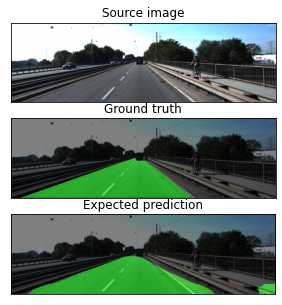

In [79]:
plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
im, gt = read_image('./um_000081.png', './um_road_000081.png')
plt.imshow(im)
plt.title('Source image')
plt.xticks([]); plt.yticks([])
plt.subplot(3,1,2)
plt.imshow(make_blending(im, gt))
plt.title('Ground truth')
plt.xticks([]); plt.yticks([])
plt.subplot(3,1,3)
pred = skimage.io.imread('./um_000081-pred.png')
plt.imshow(pred)
plt.title('Expected prediction')
plt.xticks([]); plt.yticks([])


Semantic image segmentation problem could be considered as a problem of prediction label for the central pixel in image patch of predefined size. It allows us to use a lot of NN archtectures specifically designed for image classification (thanks to ImageNet Competition)

In [80]:
def get_valid_patches(img_shape, patch_size, central_points):
    start = central_points - patch_size/2
    end = start + patch_size
    mask = np.logical_and(start >= 0, end < np.array(img_shape))
    mask = np.all(mask, axis=-1)
    return mask

def extract_patches(img, mask, n_pos=64, n_neg=64, patch_size=100):
    res = []
    labels = []
    pos = np.argwhere(mask > 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, pos)
    pos = pos[accepted_patches_mask]
    np.random.shuffle(pos)
    for i in range(n_pos):
        start = pos[i] - patch_size//2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(1)
        
    neg = np.argwhere(mask == 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, neg)
    neg = neg[accepted_patches_mask]
    np.random.shuffle(neg)
    for i in range(n_neg):
        start = neg[i] - patch_size//2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(0)
    return np.array(res), np.array(labels)

In [81]:
patches, labels = extract_patches(im, gt, 32,32, patch_size=114)

Road-centered patches

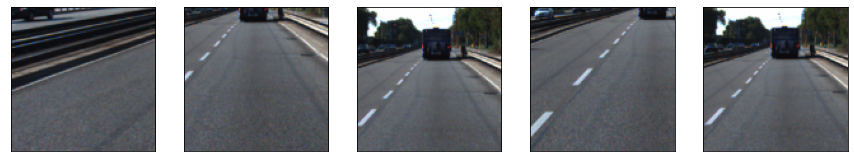

In [82]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(patches[i])
    plt.xticks([]); plt.yticks([])

Non-road-centered patches

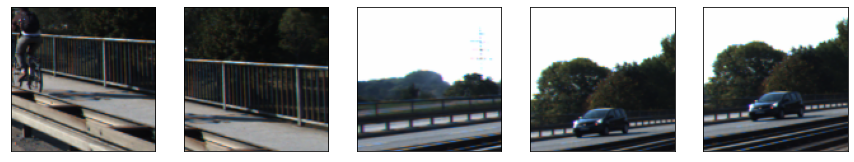

In [83]:
plt.figure(figsize=(15,3))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(patches[-i])
    plt.xticks([]); plt.yticks([])

Here is our pretrained network

In [84]:
with np.load('./model2.npz', encoding='latin1', allow_pickle=True) as f:
    weights = f['state'].tolist()  # getting np.array content; it's dict in fact, not list

In [85]:
from layer_wrappers import *
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
def create_network(weights):
    net = nn.Sequential()
    net.add_module('conv1_1', Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=False, 
                                     padding=0, weight_init=weights['conv1_1_w']))
    net.add_module('bn1_1', BatchNorm2d(num_features=32, weight_init=weights['bn1_1_w'], 
                                        bias_init=weights['bn1_1_b'], mean_init=weights['bn1_1_mean'],
                                        var_init=weights['bn1_1_var']))
    net.add_module('relu1_1', nn.ReLU(inplace=True))
    net.add_module('conv1_2', Conv2d(in_channels=32, out_channels=32, kernel_size=3, bias=False, padding=0, 
                                     weight_init=weights['conv1_2_w']))
    net.add_module('bn1_2', BatchNorm2d(num_features=32, weight_init=weights['bn1_2_w'], 
                                        bias_init=weights['bn1_2_b'], mean_init=weights['bn1_2_mean'],
                                        var_init=weights['bn1_2_var']))
    net.add_module('relu1_2', nn.ReLU(inplace=True))
    net.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))

    net.add_module('conv2_1', Conv2d(in_channels=32, out_channels=64, kernel_size=3, 
                                     dilation=1, bias=False, padding=0, weight_init=weights['conv2_1_w']))
    net.add_module('bn2_1', BatchNorm2d(num_features=64, weight_init=weights['bn2_1_w'], 
                                        bias_init=weights['bn2_1_b'], mean_init=weights['bn2_1_mean'],
                                        var_init=weights['bn2_1_var']))
    net.add_module('relu2_1', nn.ReLU(inplace=True))
    net.add_module('conv2_2', Conv2d(in_channels=64, out_channels=64, kernel_size=3, 
                                     dilation=1, bias=False, padding=0, weight_init=weights['conv2_2_w']))
    net.add_module('bn2_2', BatchNorm2d(num_features=64, weight_init=weights['bn2_2_w'], 
                                        bias_init=weights['bn2_2_b'], mean_init=weights['bn2_2_mean'],
                                        var_init=weights['bn2_2_var']))
    net.add_module('relu2_2', nn.ReLU(inplace=True))
    net.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=0))

    net.add_module('conv3_1', Conv2d(in_channels=64, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=0, weight_init=weights['conv3_1_w']))
    net.add_module('bn3_1', BatchNorm2d(num_features=128, weight_init=weights['bn3_1_w'], 
                                        bias_init=weights['bn3_1_b'], mean_init=weights['bn3_1_mean'],
                                        var_init=weights['bn3_1_var']))
    net.add_module('relu3_1', nn.ReLU(inplace=True))
    net.add_module('conv3_2', Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=0, weight_init=weights['conv3_2_w']))
    net.add_module('bn3_2', BatchNorm2d(num_features=128, weight_init=weights['bn3_2_w'], 
                                           bias_init=weights['bn3_2_b'], mean_init=weights['bn3_2_mean'],
                                        var_init=weights['bn3_2_var']))
    net.add_module('relu3_2', nn.ReLU(inplace=True))
    net.add_module('mp3', nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=0))
    
    # 'mp3' output has shape [batch_size,128, 9, 9]
    net.add_module('flatten', Flatten())
    net.add_module('fc1', Linear(in_features=128*9*9, out_features=512, bias=False, weight_init=weights['fc1_w']))
    net.add_module('fc1_bn', BatchNorm1d(num_features=512, weight_init=weights['fc1_bn_w'], 
                                         bias_init=weights['fc1_bn_b'], mean_init=weights['fc1_bn_mean'],
                                        var_init=weights['fc1_bn_var']))
    net.add_module('fc1_relu', nn.ReLU(inplace=True))
    net.add_module('fc2', Linear(in_features=512, out_features=1, bias=True, 
                                 weight_init=weights['fc2_w'], bias_init=weights['fc2_b']))
    net.add_module('probs', nn.Sigmoid())
    
    net = net.train(False)
    return net

def preproces(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches

def apply_net(input_data, net):
    input_data = Variable(torch.FloatTensor(input_data))
    output = net(input_data).data.numpy()
    return output

In [86]:
net = create_network(weights)

In [87]:
predictions = apply_net(preproces(patches), net)
predictions = (predictions > 0.5).ravel().astype(np.int32)

In [88]:
print("predictions: {}".format(predictions))
print("Accuracy: {}".format((predictions == labels).mean()))
print("Road class accuracy: {}; Non-road class accuracy: {}".format(np.mean(predictions[:32] == 1), 
                                                          np.mean(predictions[32:] == 0)))

predictions: [1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.921875
Road class accuracy: 0.84375; Non-road class accuracy: 1.0


### Your turn!

Your task is to modify the network above to make it able to take image of arbitrary size as input and produce output of the same shape.

Main changes:
* Convert Linear layer to Conv2d (Don't forget to reshape weights from [n_out_features, n_in_features] to [n_out_filters, n_in_filters, kern_size, kern_sizse])
* Replace BatchNorm1d with BatchNorm2d
* Remove Flatten module
* Remove strides from layers, add dilation in MaxPool2d and Conv2d (where it is needed)

Known troubles:
* MaxPool2d wants padding value to be less then kernel_size/2. If you need bigger value (and you will!), add nn.ConstantPad2d(padding_size, 0) before MaxPool2d (and don't forget to set padding=0 in MaxPool2d)

In [141]:
from layer_wrappers import *

def create_fully_conv_network(weights):
    net = nn.Sequential()
    net.add_module('conv1_1', Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=False, 
                                     padding=0, weight_init=weights['conv1_1_w']))
    net.add_module('bn1_1', BatchNorm2d(num_features=32, weight_init=weights['bn1_1_w'], 
                                        bias_init=weights['bn1_1_b'], mean_init=weights['bn1_1_mean'],
                                        var_init=weights['bn1_1_var']))
    net.add_module('relu1_1', nn.ReLU(inplace=True))
    net.add_module('conv1_2', Conv2d(in_channels=32, out_channels=32, kernel_size=3, bias=False, padding=0, 
                                     weight_init=weights['conv1_2_w']))
    net.add_module('bn1_2', BatchNorm2d(num_features=32, weight_init=weights['bn1_2_w'], 
                                        bias_init=weights['bn1_2_b'], mean_init=weights['bn1_2_mean'],
                                        var_init=weights['bn1_2_var']))
    net.add_module('relu1_2', nn.ReLU(inplace=True))
    net.add_module('mp1_pad', nn.ConstantPad2d(3, 0))
    net.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=1, padding=0))

    net.add_module('conv2_1', Conv2d(in_channels=32, out_channels=64, kernel_size=3, 
                                     dilation=2, bias=False, padding=2, weight_init=weights['conv2_1_w']))
    net.add_module('bn2_1', BatchNorm2d(num_features=64, weight_init=weights['bn2_1_w'], 
                                        bias_init=weights['bn2_1_b'], mean_init=weights['bn2_1_mean'],
                                        var_init=weights['bn2_1_var']))
    net.add_module('relu2_1', nn.ReLU(inplace=True))

    net.add_module('conv2_2', Conv2d(in_channels=64, out_channels=64, kernel_size=3, 
                                     dilation=1, bias=False, padding=1, weight_init=weights['conv2_2_w']))
    net.add_module('bn2_2', BatchNorm2d(num_features=64, weight_init=weights['bn2_2_w'], 
                                        bias_init=weights['bn2_2_b'], mean_init=weights['bn2_2_mean'],
                                        var_init=weights['bn2_2_var']))
    net.add_module('relu2_2', nn.ReLU(inplace=True))
    net.add_module('mp2_pad', nn.ConstantPad2d(3, 0))
    net.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=1, dilation=1, padding=0))

    net.add_module('conv3_1', Conv2d(in_channels=64, out_channels=128, kernel_size=3, 
                                        dilation=2, bias=False, padding=0, weight_init=weights['conv3_1_w']))
    net.add_module('bn3_1', BatchNorm2d(num_features=128, weight_init=weights['bn3_1_w'], 
                                        bias_init=weights['bn3_1_b'], mean_init=weights['bn3_1_mean'],
                                        var_init=weights['bn3_1_var']))
    net.add_module('relu3_1', nn.ReLU(inplace=True))

    net.add_module('conv3_2', Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=0, weight_init=weights['conv3_2_w']))
    net.add_module('bn3_2', BatchNorm2d(num_features=128, weight_init=weights['bn3_2_w'], 
                                           bias_init=weights['bn3_2_b'], mean_init=weights['bn3_2_mean'],
                                        var_init=weights['bn3_2_var']))
    net.add_module('relu3_2', nn.ReLU(inplace=True))
    net.add_module('mp3_pad', nn.ConstantPad2d(10, 0))
    net.add_module('mp3', nn.MaxPool2d(kernel_size=3, stride=1, dilation=1, padding=0))
    
    # 'mp3' output has shape [batch_size,128, 9, 9]
    net.add_module('fc1', Conv2d(in_channels=128, out_channels=512, kernel_size=9,
                                 dilation=2, bias=False, padding=0,
                                 weight_init=weights['fc1_w'].reshape([512, 128, 9, 9])))
    net.add_module('fc1_bn', BatchNorm2d(num_features=512, weight_init=weights['fc1_bn_w'], 
                                         bias_init=weights['fc1_bn_b'], mean_init=weights['fc1_bn_mean'],
                                        var_init=weights['fc1_bn_var']))
    net.add_module('fc1_relu', nn.ReLU(inplace=True))
    net.add_module('fc2', Conv2d(in_channels=512, out_channels=1, kernel_size=1, bias=True, 
                                 weight_init=weights['fc2_w'].reshape([1, 512, 1, 1]), bias_init=weights['fc2_b']))

    net.add_module('probs', nn.Sigmoid())
    net = net.train(False)
    return net

def preproces(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches

def apply_net(input_data, net):
    input_data = Variable(torch.FloatTensor(input_data))
    output = net(input_data).data.numpy()
    return output

In [142]:
net2 = create_fully_conv_network(weights)

In [143]:
predictions = apply_net(preproces(patches[:5]), net2)
assert predictions.shape[-2:] == patches.shape[1:3], "{}, {}".format(predictions.shape, patches.shape)

Let's visualize what we finally have got

([], <a list of 0 Text major ticklabel objects>)

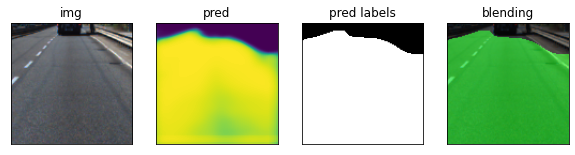

In [144]:
plt.figure(figsize=(10,4))
patch_index = 1
plt.subplot(1,4,1)
plt.title('img')
plt.imshow(patches[patch_index])
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,2)
plt.title('pred')
plt.imshow(predictions[patch_index,0])
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,3)
plt.title('pred labels')
plt.imshow(predictions[patch_index,0] > 0.5, 'gray')
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,4)
plt.title('blending')
plt.imshow(make_blending(patches[patch_index], predictions[patch_index,0] > 0.5))
plt.xticks([]); plt.yticks([])

If everything is fine, you should be able to predict output for input image of any shape. Try crop 256x256 (or smaller if it doesn't fit in memory)

(256, 848, 3)


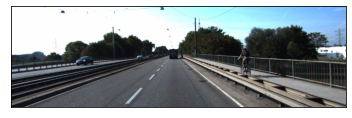

In [145]:
plt.imshow(im)
plt.xticks([]); plt.yticks([])
print(im.shape)

In [146]:
patch = im[:, 200:200+256]
predictions = apply_net(preproces(patch[np.newaxis]), net2)
predictions.shape, patch.shape

((1, 1, 256, 256), (256, 256, 3))

([], <a list of 0 Text major ticklabel objects>)

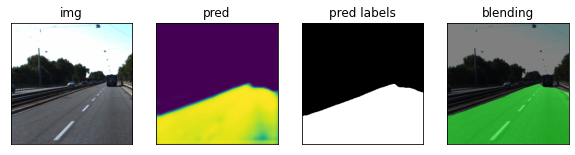

In [147]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.title('img')
plt.imshow(patch)
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,2)
plt.title('pred')
plt.imshow(predictions[0,0])
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,3)
plt.title('pred labels')
plt.imshow(predictions[0,0] > 0.5, 'gray')
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,4)
plt.title('blending')
plt.imshow(make_blending(patch, predictions[0,0] > 0.5))
plt.xticks([]); plt.yticks([])

In [23]:
def split_and_apply(net, image, patch_w=150, overlap=80):
    n_patches = image.shape[1] // patch_w
    labels = np.zeros(image.shape[:2], np.uint8)
    for i in range(n_patches):
        print(i,n_patches)
        patch = image[:, max(0, i*patch_w-overlap): min((i+1)*patch_w+overlap, image.shape[1])]
        extra_left = i*patch_w - max(0, i*patch_w-overlap)
        extra_right = min(image.shape[1], (i+1)*patch_w+overlap) - (i+1)*patch_w
        out = (apply_net(preproces(patch[np.newaxis]), net)[0,0] > 0.5).astype(np.uint8)
        labels[:, i*patch_w: (i+1)*patch_w] = out[:,extra_left:-extra_right]
    if n_patches*patch_w < image.shape[1]:
        last_patch_size = image.shape[1] - n_patches*patch_w
        patch = image[:,-patch_w:]
        labels[:,-last_patch_size:] = (apply_net(preproces(patch[np.newaxis]), net)[0,0] > 0.5).astype(np.uint8)[:,-last_patch_size:]
    return labels

In [24]:
#!M
labels = split_and_apply(net2, im)

0 5
1 5
2 5
3 5
4 5


([], <a list of 0 Text major ticklabel objects>)

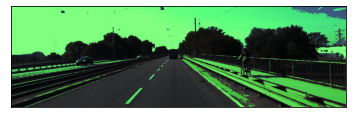

In [25]:
plt.imshow(make_blending(im, labels))
plt.xticks([]); plt.yticks([])

### TL;DR DeepLab v2 architecture:
![alt text](https://miro.medium.com/max/1283/1*8Lg66z7e7ijuLmSkOzhYvA.png "Somthing wrong with image")